We demonstrate how to find the minimal outer ellipsoid of a basic semi-algebraic set. We can find such outer ellipsoid through a convex optimization problem.

In [15]:
import jupyter_black

jupyter_black.load()
import numpy as np
import matplotlib.pyplot as plt
import minimal_outer_ellipsoid.ellipsoid as ellipsoid
import pydrake.solvers as solvers
import pydrake.symbolic as sym

First we show a 2D example, where we find the minimal ellipsoid of the following shape $\{x | x_0^4 + x_1^4 -1.925x_0^2x_1^2\le 1, x_1 \le 1.25\}$

/tmp/ipykernel_44552/281747192.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


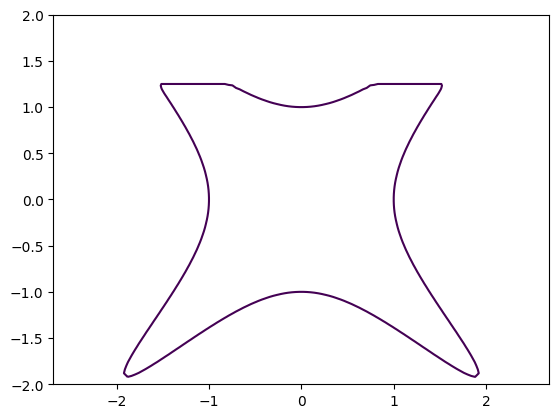

In [16]:
# Plot the inner shape {x | x₀⁴+x₁⁴−1.925x₀²x₁²≤ 1, x₁≤ 1.25}.
def plot_inner_shape(ax):
    X, Y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
    Z1 = X**4 + Y**4 - 1.925 * X**2 * Y**2 - 1
    Z2 = Y - 1.25
    Z = np.max(
        np.concatenate(
            (np.expand_dims(Z1, axis=2), np.expand_dims(Z2, axis=2)), axis=2
        ),
        axis=2,
    )
    ax.contour(X, Y, Z, [0])


fig = plt.figure()
ax = fig.add_subplot()
plot_inner_shape(ax)
ax.axis("equal")
fig.show()

Now we search the minimal outer ellipsoid through a convex optimization problem.

In [17]:
prog = solvers.MathematicalProgram()
x = prog.NewIndeterminates(2)
inner_polynomials = np.array(
    [
        sym.Polynomial(
            x[0] ** 4 + x[1] ** 4 - 1.925 * x[0] ** 2 * x[1] ** 2 - 1
        ),
        sym.Polynomial(x[1] - 1.25),
    ]
)
S = prog.NewSymmetricContinuousVariables(2, "S")
b = prog.NewContinuousVariables(2, "b")
c = prog.NewContinuousVariables(1, "c")[0]
ellipsoid.add_containment_constraint(
    prog,
    x,
    inner_polynomials,
    S,
    b,
    c,
    inner_poly_lagrangians_degrees=[2, 6],
    ellipsoid_lagrangian=sym.Polynomial(x[0] ** 2 + x[1] ** 2),
)
ellipsoid.add_minimize_volume_cost(prog, S, b, c)
result = solvers.Solve(prog)
assert result.is_success()
S_sol = result.GetSolution(S)
b_sol = result.GetSolution(b)
c_sol = result.GetSolution(c)

/tmp/ipykernel_44552/2190171846.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


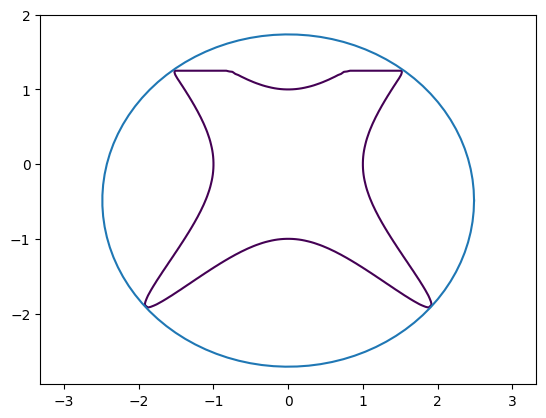

In [18]:
# Now we plot the optimized ellipsoid.

A, d = ellipsoid.to_affine_ball(S_sol, b_sol, c_sol)

theta = np.linspace(0, 2 * np.pi, 100)
fig = plt.figure()
ax = fig.add_subplot()
plot_inner_shape(ax)
ellipsoid_contour = A @ (
    np.concatenate(
        [np.cos(theta).reshape(1, -1), np.sin(theta).reshape(1, -1)], axis=0
    )
    + d.reshape((2, 1))
)
ax.plot(ellipsoid_contour[0], ellipsoid_contour[1])
ax.axis("equal")
fig.show()